In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 0

# baseline: 
exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
exp_base_model = os.path.join(LOG_DIR, exp_base[TEST_FOLD])
# Jelmers base model with brier-score
# Fold 2: 20180329_08_02_33_dcnnv1_150000E_lr2e04
# Fold 0: 20180331_09_48_22_dcnnv1_150000E_lr2e02
exp_base_bs = {2: "20180329_08_02_33_dcnnv1_150000E_lr2e04",
               0: "20180331_09_48_22_dcnnv1_150000E_lr2e02"}
exp_base_bs_model = os.path.join(LOG_DIR, exp_base_bs[TEST_FOLD])
# MC dropout models
# Fold 2: 20180328_10_54_36_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180330_09_56_01_dcnn_mcv1_150000E_lr2e02
exp_mc005 = {2: "20180328_10_54_36_dcnn_mcv1_150000E_lr2e02",
             0: "20180330_09_56_01_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_model = os.path.join(LOG_DIR, exp_mc005[TEST_FOLD])
# Fold 2: 20180329_08_04_12_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180331_09_49_14_dcnn_mcv1_150000E_lr2e02
exp_mc005_bs = {2: "20180329_08_04_12_dcnn_mcv1_150000E_lr2e04",
                0: "20180331_09_49_14_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_bs_model = os.path.join(LOG_DIR, exp_mc005_bs[TEST_FOLD])

# Fold 2: 20180328_10_54_55_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180330_09_56_15_dcnn_mcv1_150000E_lr2e02
exp_mc01 = {2: "20180328_10_54_55_dcnn_mcv1_150000E_lr2e02",
            0: "20180330_09_56_15_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_model = os.path.join(LOG_DIR, exp_mc01[TEST_FOLD])
# Fold 2: 20180329_08_03_29_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180331_09_48_48_dcnn_mcv1_150000E_lr2e02
exp_mc01_bs = {2: "20180329_08_03_29_dcnn_mcv1_150000E_lr2e04",
               0: "20180331_09_48_48_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_bs_model = os.path.join(LOG_DIR, exp_mc01_bs[TEST_FOLD])

# Fold 2: 20180329_08_26_03_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180404_09_06_37_dcnn_mcv1_150000E_lr2e02
exp_mc02 = {2: "20180329_08_26_03_dcnn_mcv1_150000E_lr2e02",
            0: "20180404_09_06_37_dcnn_mcv1_150000E_lr2e02"}
exp_mc02_model = os.path.join(LOG_DIR, exp_mc02[TEST_FOLD])
# Fold 2: 20180331_10_03_03_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180404_09_12_48_dcnn_mcv1_150000E_lr2e04
exp_mc02_bs = {2: "20180331_10_03_03_dcnn_mcv1_150000E_lr2e04",
               0: "20180404_09_12_48_dcnn_mcv1_150000E_lr2e04"}
exp_mc02_bs_model = os.path.join(LOG_DIR, exp_mc02_bs[TEST_FOLD])

# Fold 2: 20180329_08_42_47_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180404_09_05_00_dcnn_mcv1_150000E_lr2e02
exp_mc03 = {2: "20180329_08_42_47_dcnn_mcv1_150000E_lr2e02",
            0: "20180404_09_05_00_dcnn_mcv1_150000E_lr2e02"}
exp_mc03_model = os.path.join(LOG_DIR, exp_mc03[TEST_FOLD])
# Fold 2: 20180331_10_02_23_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180405_08_32_07_dcnn_mcv1_150000E_lr2e04
exp_mc03_bs = {2: "20180331_10_02_23_dcnn_mcv1_150000E_lr2e04",
               0: "20180405_08_32_07_dcnn_mcv1_150000E_lr2e04"}
exp_mc03_bs_model = os.path.join(LOG_DIR, exp_mc03_bs[TEST_FOLD])

## Load experimental data and test data set

In [3]:
exper_base = ExperimentHandler.load_experiment(exp_base_model)

print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)
exper_hdl_base.set_model_name("DCNN baseline fold-{}".format(exper_hdl_base.exper.run_args.fold_ids[0]))
print("Model name {}".format(exper_hdl_base.exper.model_name))

exper_base_bs = ExperimentHandler.load_experiment(exp_base_bs_model)
exper_hdl_base_bs = ExperimentHandler(exper_base_bs, use_logfile=False)
exper_hdl_base_bs.set_root_dir(ROOT_DIR)
exper_hdl_base_bs.set_model_name("DCNN-BS baseline fold-{}".format(exper_hdl_base_bs.exper.run_args.fold_ids[0]))
print("Model name {}".format(exper_hdl_base_bs.exper.model_name))

# exp_base_model_exper1 = os.path.join(LOG_DIR, "20180319_10_49_05_dcnnv1_150000E_lr2e02")
# exper_base_exper1 = ExperimentHandler.load_experiment(exp_base_model_exper1)
# exper_hdl_base_exper1 = ExperimentHandler(exper_base_exper1, use_logfile=False)
# exper_hdl_base_exper1.set_root_dir(ROOT_DIR)
# exper_hdl_base_exper1.set_model_name("DCNN baseline exper1")
# print("Model name {}".format(exper_hdl_base_exper1.exper.model_name))

# exper_base_bs = ExperimentHandler.load_experiment(exp_base_bs_model)
# exper_hdl_base_bs = ExperimentHandler(exper_base_bs, use_logfile=False)
# exper_hdl_base_bs.set_root_dir(ROOT_DIR)
# exper_hdl_base_bs.set_model_name("DCNN baseline (Brier-loss)")

exper_mc005 = ExperimentHandler.load_experiment(exp_mc005_model)
exper_hdl_mc005 = ExperimentHandler(exper_mc005, use_logfile=False)
exper_hdl_mc005.set_root_dir(ROOT_DIR)
exper_hdl_mc005.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc005.exper.run_args.fold_ids[0],
    exper_hdl_mc005.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005.exper.model_name))

exper_mc005_bs = ExperimentHandler.load_experiment(exp_mc005_bs_model)
exper_hdl_mc005_bs = ExperimentHandler(exper_mc005_bs, use_logfile=False)
exper_hdl_mc005_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc005_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
    exper_hdl_mc005_bs.exper.run_args.fold_ids[0],
    exper_hdl_mc005_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_bs.exper.model_name))

exper_mc01 = ExperimentHandler.load_experiment(exp_mc01_model)
exper_hdl_mc01 = ExperimentHandler(exper_mc01, use_logfile=False)
exper_hdl_mc01.set_root_dir(ROOT_DIR)
exper_hdl_mc01.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc01.exper.run_args.fold_ids[0],
    exper_hdl_mc01.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01.exper.model_name))

exper_mc01_bs = ExperimentHandler.load_experiment(exp_mc01_bs_model)
exper_hdl_mc01_bs = ExperimentHandler(exper_mc01_bs, use_logfile=False)
exper_hdl_mc01_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc01_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
    exper_hdl_mc01_bs.exper.run_args.fold_ids[0],
    exper_hdl_mc01_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_bs.exper.model_name))


exper_mc02 = ExperimentHandler.load_experiment(exp_mc02_model)
exper_hdl_mc02 = ExperimentHandler(exper_mc02, use_logfile=False)
exper_hdl_mc02.set_root_dir(ROOT_DIR)
exper_hdl_mc02.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc02.exper.run_args.fold_ids[0],
    exper_hdl_mc02.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc02.exper.model_name))

exper_mc02_bs = ExperimentHandler.load_experiment(exp_mc02_bs_model)
exper_hdl_mc02_bs = ExperimentHandler(exper_mc02_bs, use_logfile=False)
exper_hdl_mc02_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc02_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
    exper_hdl_mc02_bs.exper.run_args.fold_ids[0],
    exper_hdl_mc02_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc02_bs.exper.model_name))


exper_mc03 = ExperimentHandler.load_experiment(exp_mc03_model)
exper_hdl_mc03 = ExperimentHandler(exper_mc03, use_logfile=False)
exper_hdl_mc03.set_root_dir(ROOT_DIR)
exper_hdl_mc03.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc03.exper.run_args.fold_ids[0],
    exper_hdl_mc03.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc03.exper.model_name))


exper_mc03_bs = ExperimentHandler.load_experiment(exp_mc03_bs_model)
exper_hdl_mc03_bs = ExperimentHandler(exper_mc03_bs, use_logfile=False)
exper_hdl_mc03_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc03_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
        exper_hdl_mc03_bs.exper.run_args.fold_ids[0],
        exper_hdl_mc03_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc03_bs.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_base.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, val_only=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_39_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 0
Model name DCNN baseline fold-0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180331_09_48_22_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
Model name DCNN-BS baseline fold-0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180331_09_49_14_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-BS-dropout fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_15_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.1)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180331_09_48_48_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-BS-d

  4%|▍         | 1/25 [00:00<00:12,  1.98it/s]/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


2 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient017_frame01.mhd
3 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient017_frame09.mhd


  8%|▊         | 2/25 [00:01<00:12,  1.84it/s]

4 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient018_frame01.mhd
5 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient018_frame10.mhd


 12%|█▏        | 3/25 [00:01<00:11,  1.95it/s]

6 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient019_frame01.mhd
7 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient019_frame11.mhd


 16%|█▌        | 4/25 [00:02<00:11,  1.88it/s]

8 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient020_frame01.mhd
9 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient020_frame11.mhd


 20%|██        | 5/25 [00:02<00:11,  1.82it/s]

10 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient036_frame01.mhd
11 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient036_frame12.mhd


 24%|██▍       | 6/25 [00:03<00:10,  1.87it/s]

12 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient037_frame01.mhd
13 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient037_frame12.mhd


 28%|██▊       | 7/25 [00:03<00:09,  1.81it/s]

14 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient038_frame01.mhd
15 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient038_frame11.mhd


 32%|███▏      | 8/25 [00:04<00:08,  1.89it/s]

16 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient039_frame01.mhd
17 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient039_frame10.mhd


 36%|███▌      | 9/25 [00:04<00:08,  1.86it/s]

18 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient040_frame01.mhd
19 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient040_frame13.mhd


 40%|████      | 10/25 [00:05<00:08,  1.86it/s]

20 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient056_frame01.mhd
21 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient056_frame12.mhd


 44%|████▍     | 11/25 [00:05<00:07,  1.89it/s]

22 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient057_frame01.mhd
23 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient057_frame09.mhd


 48%|████▊     | 12/25 [00:06<00:06,  1.86it/s]

24 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient058_frame01.mhd
25 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient058_frame14.mhd


 52%|█████▏    | 13/25 [00:06<00:06,  1.87it/s]

26 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient059_frame01.mhd
27 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient059_frame09.mhd


 56%|█████▌    | 14/25 [00:07<00:05,  1.90it/s]

28 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient060_frame01.mhd
29 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient060_frame14.mhd


 60%|██████    | 15/25 [00:08<00:05,  1.86it/s]

30 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient076_frame01.mhd
31 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient076_frame12.mhd


 64%|██████▍   | 16/25 [00:08<00:04,  1.84it/s]

32 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient077_frame01.mhd
33 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient077_frame09.mhd


 68%|██████▊   | 17/25 [00:09<00:04,  1.86it/s]

34 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient078_frame01.mhd
35 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient078_frame09.mhd


 72%|███████▏  | 18/25 [00:09<00:03,  1.87it/s]

36 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient079_frame01.mhd
37 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient079_frame11.mhd


 76%|███████▌  | 19/25 [00:10<00:03,  1.87it/s]

38 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient080_frame01.mhd
39 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient080_frame10.mhd


 80%|████████  | 20/25 [00:10<00:02,  1.87it/s]

40 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient096_frame01.mhd
41 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient096_frame08.mhd


 84%|████████▍ | 21/25 [00:11<00:02,  1.83it/s]

42 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient097_frame01.mhd
43 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient097_frame11.mhd


 88%|████████▊ | 22/25 [00:11<00:01,  1.84it/s]

44 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient098_frame01.mhd
45 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient098_frame09.mhd


 92%|█████████▏| 23/25 [00:12<00:01,  1.87it/s]

46 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient099_frame01.mhd
47 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient099_frame09.mhd


 96%|█████████▌| 24/25 [00:13<00:00,  1.84it/s]

48 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient100_frame01.mhd
49 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images/patient100_frame13.mhd


100%|██████████| 25/25 [00:13<00:00,  1.85it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Run model evaluation of test set

In [7]:
mc_samples = 10
sample_weights = True
store_details = False
image_range = None
generate_stats = False
save_results = False

exper_handler = exper_hdl_mc005

exper_handler.logger = None   # exper_hdl_base

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=False, referral_threshold=0., image_range=image_range, checkpoints=None,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True)


    
print("Ready")

Evaluating model MC-dropout fold-0 (p=0.05) - runID 1
INFO - Running test on 25 images with model from checkpoint 100000
Image 1 - Test accuracy: test loss -1.461	 dice(RV/Myo/LV): ES 0.84/0.79/0.94 --- ED 0.94/0.83/0.95
Image 1 - Test accuracy: test loss -1.461	 Hausdorff(RV/Myo/LV): ES 17.09/18.57/11.88 --- ED 16.33/18.15/15.08
Image 2 - Test accuracy: test loss -3.124	 dice(RV/Myo/LV): ES 0.85/0.81/0.94 --- ED 0.94/0.81/0.96
Image 2 - Test accuracy: test loss -3.124	 Hausdorff(RV/Myo/LV): ES 19.50/16.33/20.00 --- ED 15.01/8.16/15.08
Image 3 - Test accuracy: test loss -1.876	 dice(RV/Myo/LV): ES 0.90/0.82/0.95 --- ED 0.90/0.82/0.97
Image 3 - Test accuracy: test loss -1.876	 Hausdorff(RV/Myo/LV): ES 17.32/11.54/11.54 --- ED 25.55/12.21/10.66
Image 4 - Test accuracy: test loss -1.098	 dice(RV/Myo/LV): ES 0.90/0.89/0.96 --- ED 0.92/0.88/0.97
Image 4 - Test accuracy: test loss -1.098	 Hausdorff(RV/Myo/LV): ES 16.09/10.10/10.00 --- ED 22.40/10.38/10.10
Image 5 - Test accuracy: test loss -

Image 14 - Test accuracy: test loss -1.406	 dice(RV/Myo/LV): ES 0.75/0.88/0.94 --- ED 0.95/0.84/0.96
Image 14 - Test accuracy: test loss -1.406	 Hausdorff(RV/Myo/LV): ES 15.08/9.39/11.55 --- ED 19.60/10.48/7.92
Image 15 - Test accuracy: test loss -2.218	 dice(RV/Myo/LV): ES 0.65/0.81/0.92 --- ED 0.80/0.81/0.97
Image 15 - Test accuracy: test loss -2.218	 Hausdorff(RV/Myo/LV): ES 28.76/14.07/12.52 --- ED 14.00/8.96/8.96
Image 16 - Test accuracy: test loss -1.765	 dice(RV/Myo/LV): ES 0.68/0.85/0.92 --- ED 0.93/0.82/0.95
Image 16 - Test accuracy: test loss -1.765	 Hausdorff(RV/Myo/LV): ES 29.57/9.39/10.00 --- ED 15.65/17.20/10.38
Image 17 - Test accuracy: test loss -1.000	 dice(RV/Myo/LV): ES 0.75/0.87/0.81 --- ED 0.91/0.88/0.97
Image 17 - Test accuracy: test loss -1.000	 Hausdorff(RV/Myo/LV): ES 24.29/18.57/15.08 --- ED 12.52/16.02/5.77
Image 18 - Test accuracy: test loss -3.041	 dice(RV/Myo/LV): ES 0.77/0.91/0.94 --- ED 0.96/0.88/0.97
Image 18 - Test accuracy: test loss -3.041	 Hausdorff

Image 2 - Test accuracy: test loss -3.071	 dice(RV/Myo/LV): ES 0.86/0.82/0.94 --- ED 0.94/0.81/0.96
Image 2 - Test accuracy: test loss -3.071	 Hausdorff(RV/Myo/LV): ES 19.55/16.63/20.00 --- ED 16.86/17.93/16.33
Image 3 - Test accuracy: test loss -1.850	 dice(RV/Myo/LV): ES 0.90/0.82/0.95 --- ED 0.91/0.82/0.97
Image 3 - Test accuracy: test loss -1.850	 Hausdorff(RV/Myo/LV): ES 23.55/10.66/11.54 --- ED 25.36/12.29/7.00
Image 4 - Test accuracy: test loss -1.043	 dice(RV/Myo/LV): ES 0.89/0.88/0.96 --- ED 0.94/0.88/0.98
Image 4 - Test accuracy: test loss -1.043	 Hausdorff(RV/Myo/LV): ES 14.07/14.28/6.26 --- ED 15.08/19.55/10.38
Image 5 - Test accuracy: test loss -1.546	 dice(RV/Myo/LV): ES 0.81/0.82/0.92 --- ED 0.94/0.77/0.95
Image 5 - Test accuracy: test loss -1.546	 Hausdorff(RV/Myo/LV): ES 18.36/14.62/20.00 --- ED 39.42/14.00/20.00
Image 6 - Test accuracy: test loss -1.654	 dice(RV/Myo/LV): ES 0.77/0.90/0.93 --- ED 0.93/0.85/0.95
Image 6 - Test accuracy: test loss -1.654	 Hausdorff(RV/My

Image 16 - Test accuracy: test loss -1.892	 dice(RV/Myo/LV): ES 0.72/0.85/0.92 --- ED 0.94/0.82/0.95
Image 16 - Test accuracy: test loss -1.892	 Hausdorff(RV/Myo/LV): ES 20.20/16.39/10.00 --- ED 13.43/20.34/11.20
Image 17 - Test accuracy: test loss -0.990	 dice(RV/Myo/LV): ES 0.75/0.86/0.80 --- ED 0.92/0.89/0.97
Image 17 - Test accuracy: test loss -0.990	 Hausdorff(RV/Myo/LV): ES 24.29/14.82/16.57 --- ED 11.46/16.02/10.00
Image 18 - Test accuracy: test loss -3.186	 dice(RV/Myo/LV): ES 0.76/0.91/0.94 --- ED 0.96/0.90/0.97
Image 18 - Test accuracy: test loss -3.186	 Hausdorff(RV/Myo/LV): ES 14.62/7.14/10.10 --- ED 5.60/5.60/3.13
Image 19 - Test accuracy: test loss -1.457	 dice(RV/Myo/LV): ES 0.73/0.88/0.92 --- ED 0.94/0.86/0.97
Image 19 - Test accuracy: test loss -1.457	 Hausdorff(RV/Myo/LV): ES 12.52/14.00/12.29 --- ED 22.92/7.92/7.14
Image 20 - Test accuracy: test loss -2.355	 dice(RV/Myo/LV): ES 0.80/0.91/0.94 --- ED 0.96/0.89/0.97
Image 20 - Test accuracy: test loss -2.355	 Hausdorff

[5, 9, 14]


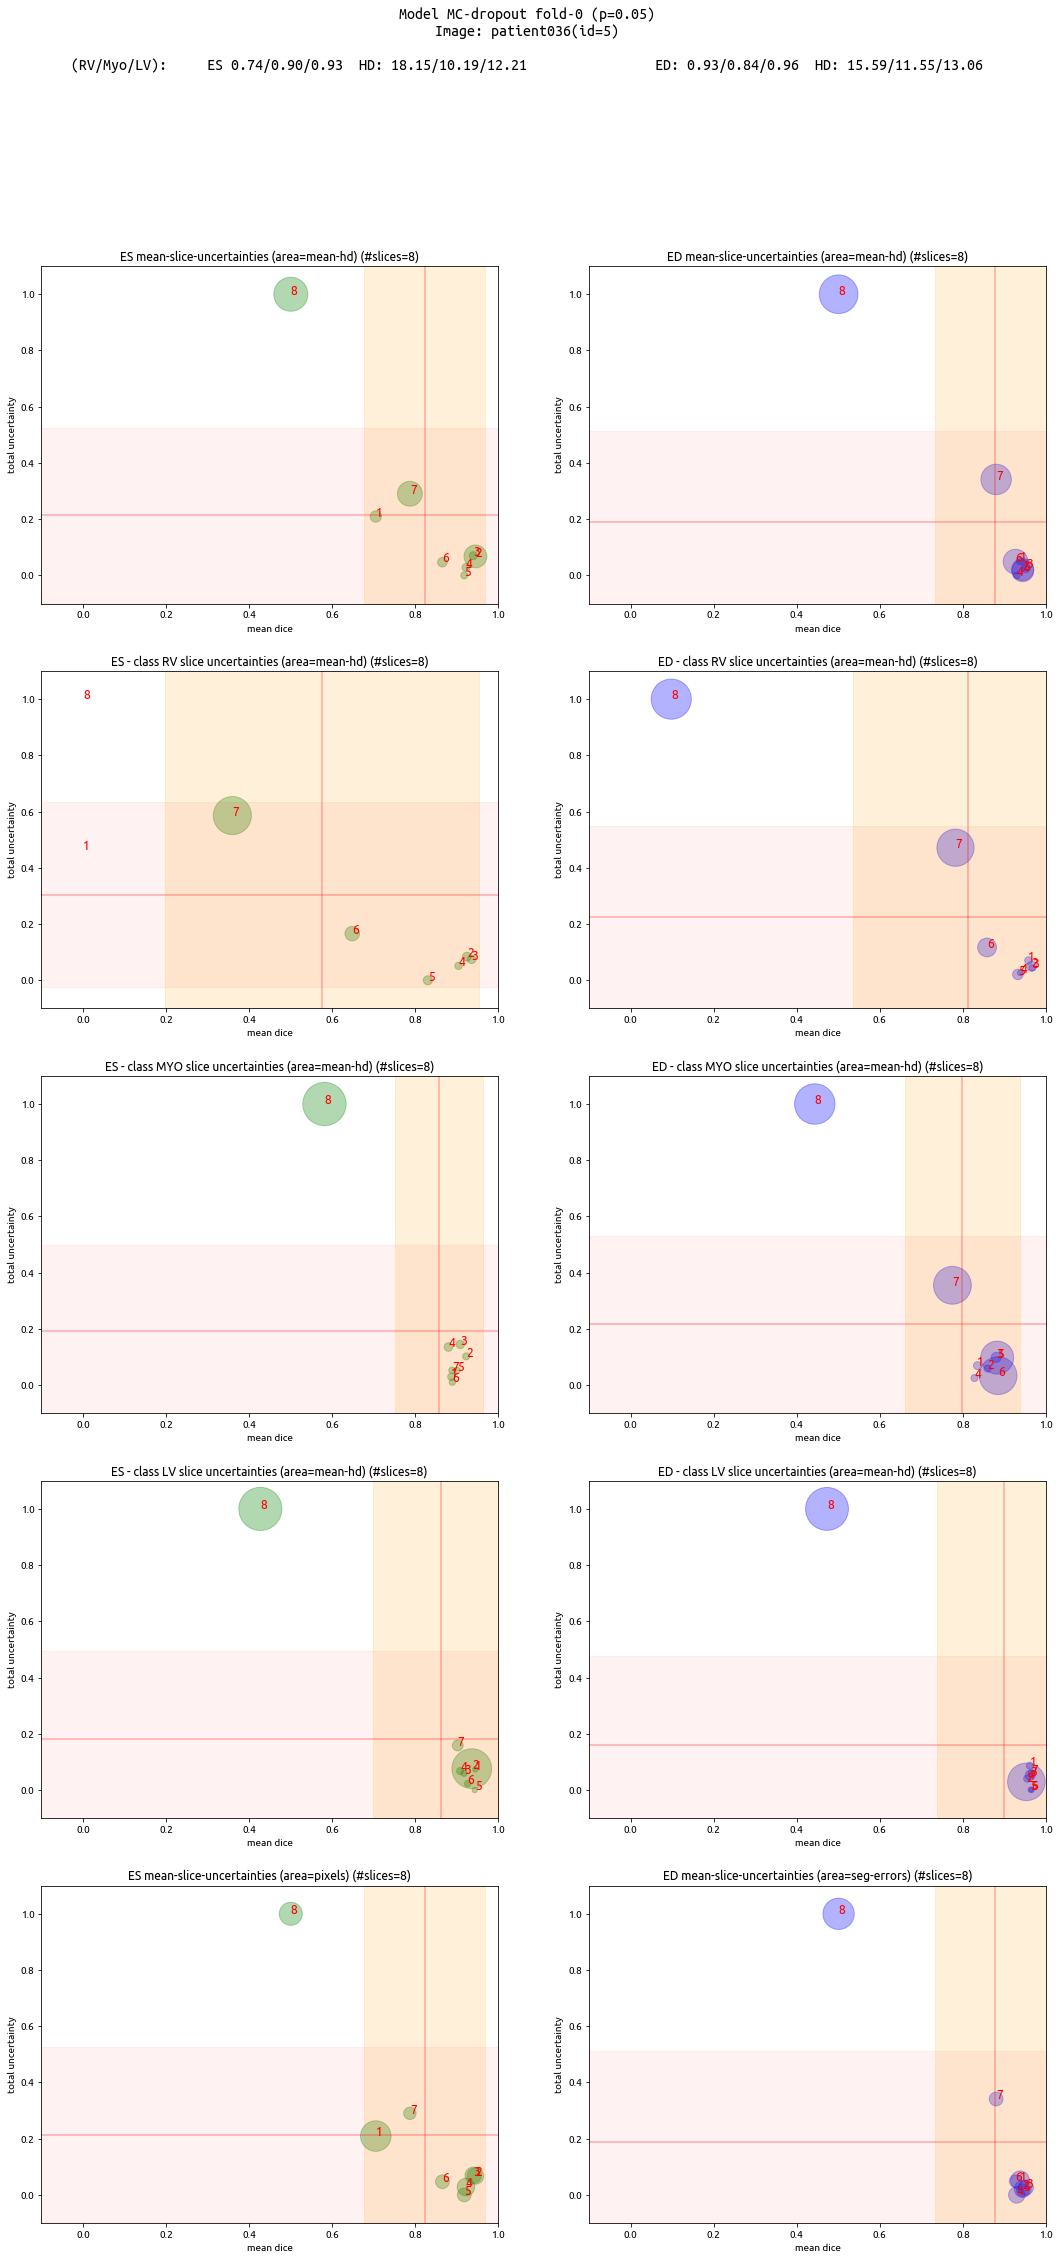

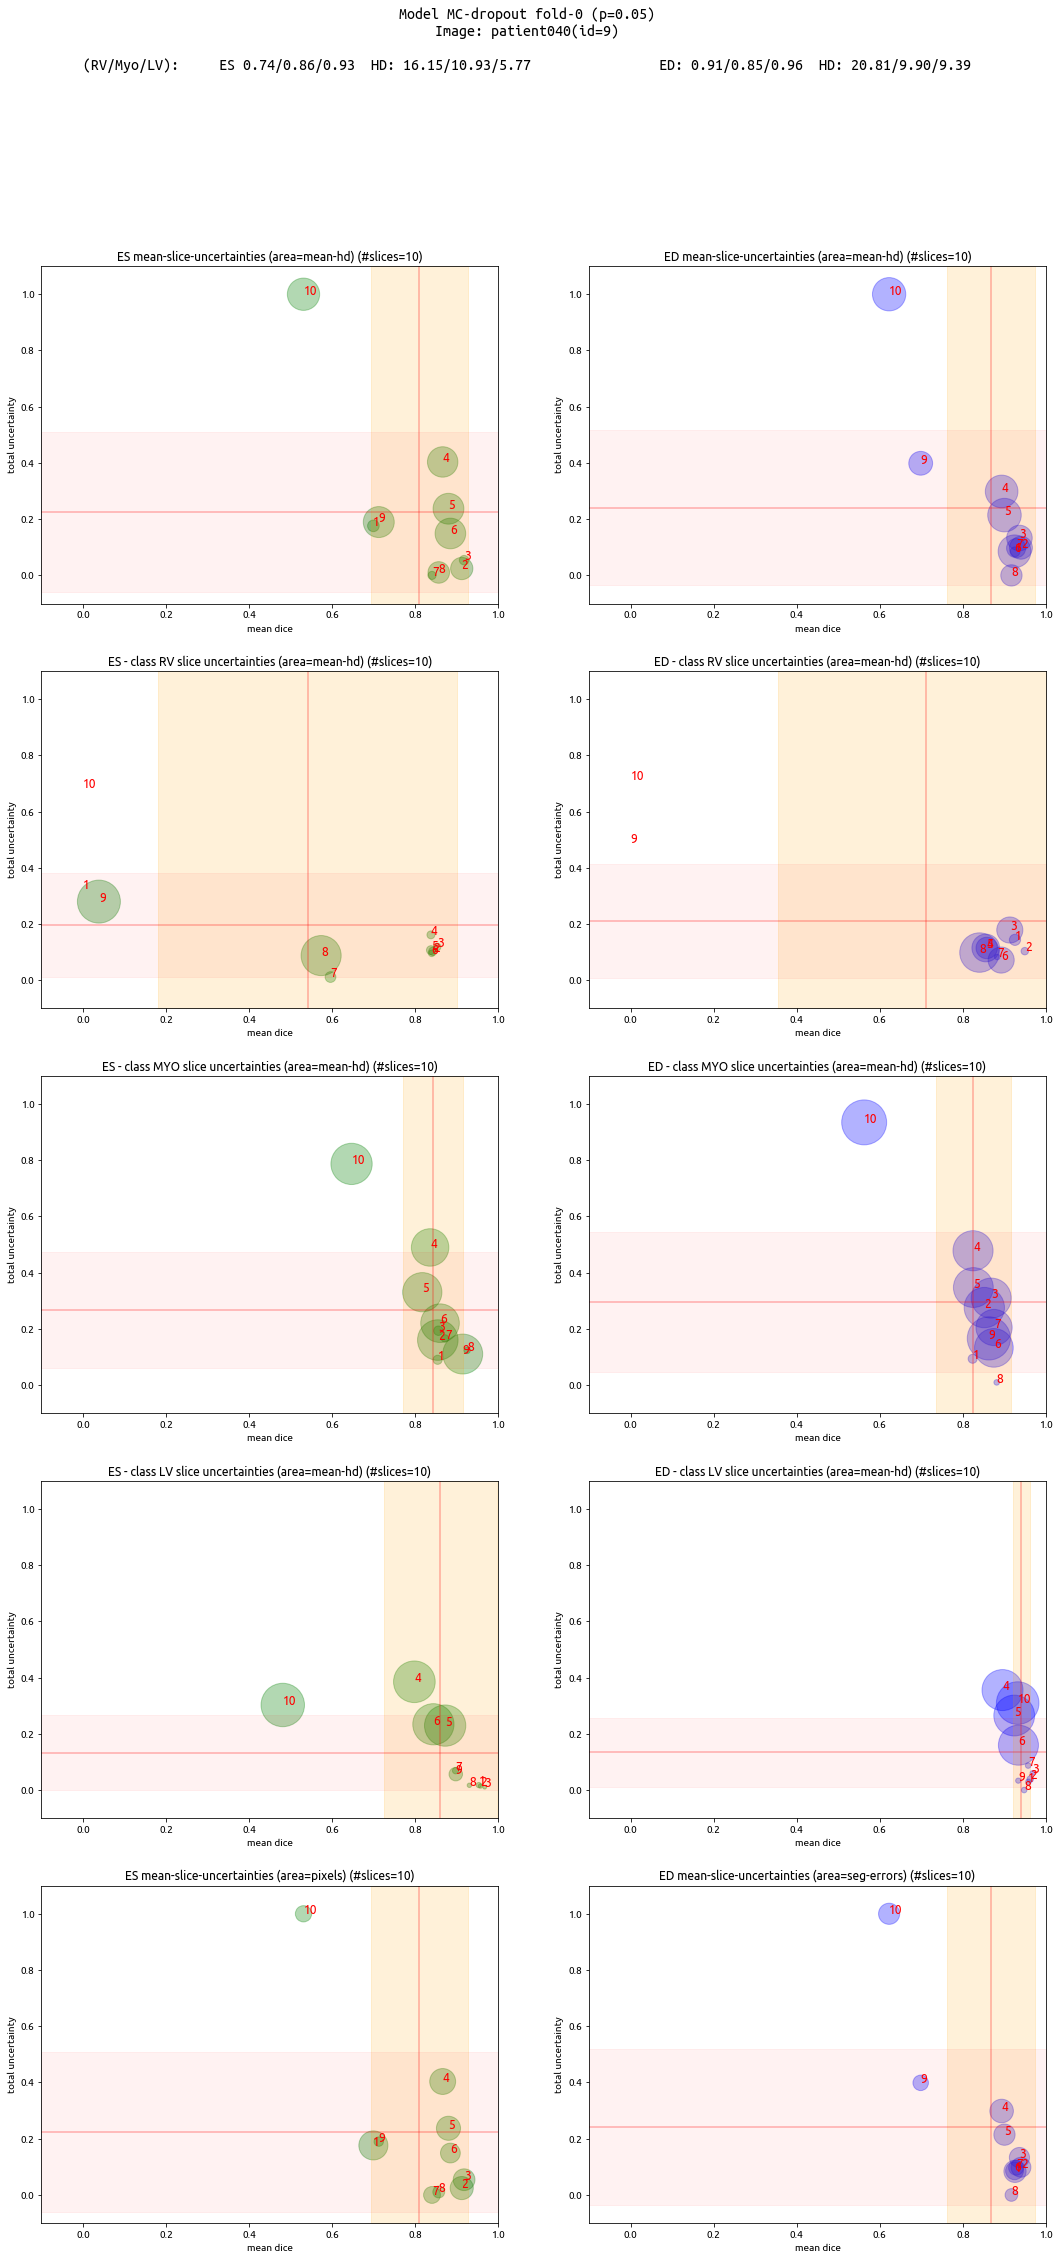

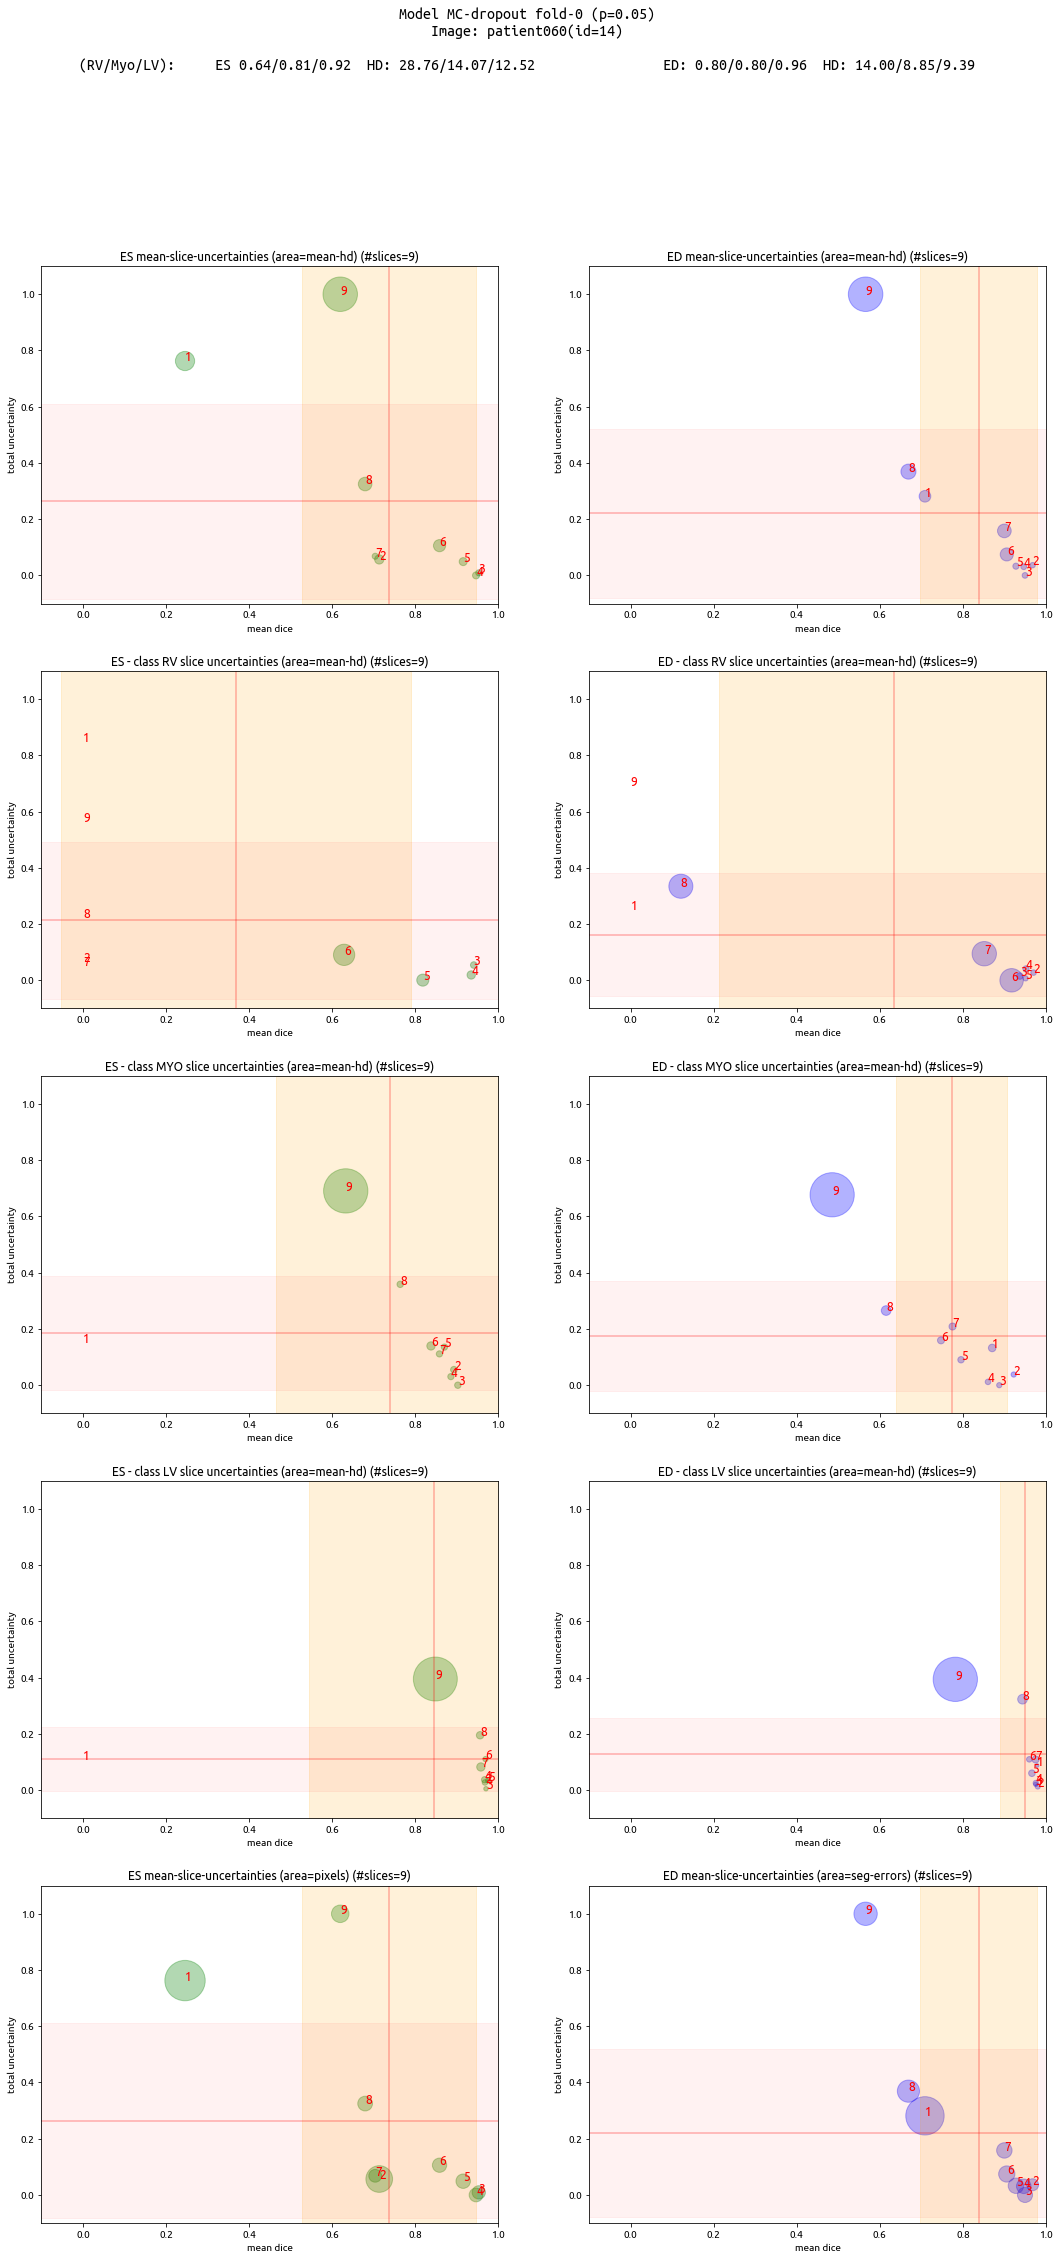

In [53]:
exper_handler = exper_hdl_mc005

image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=False, do_show=True, u_type=u_type,
               translate_img_range=True)

In [39]:
sample_weights = True
mc_samples = 10
store_details = True
image_range = [5, 9, 14]
generate_stats = True

save_results = False
#  exper_hdl_mc01 exper_hdl_mc025 exp_hdl_mc01_bs  exper_hdl_mc04  exp_hdl_mc01_bs
exper_handler = exper_hdl_mc005
exper_handler.logger = None

print("INFO - Evaluating model {}".format(exper_handler.exper.model_name))

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,
              use_uncertainty=False, referral_threshold=0., image_range=image_range, verbose=False, 
              reset_results=True, use_seed=True,
              store_details=store_details, generate_stats=generate_stats, save_results=save_results,
              do_filter=True, checkpoints=[150000], u_threshold=0.25)


    
print("Ready")



INFO - Evaluating model MC-dropout fold-0 (p=0.05)
Evaluating model MC-dropout fold-0 (p=0.05) - runID 1
INFO - Running test on 3 images with model from checkpoint 150000
Image 6 - Test accuracy: test loss -1.655	 dice(RV/Myo/LV): ES 0.74/0.90/0.93 --- ED 0.93/0.84/0.96
Image 6 - Test accuracy: test loss -1.655	 Hausdorff(RV/Myo/LV): ES 18.15/10.19/12.21 --- ED 15.59/11.55/13.06
Image 10 - Test accuracy: test loss -1.963	 dice(RV/Myo/LV): ES 0.74/0.86/0.93 --- ED 0.91/0.85/0.96
Image 10 - Test accuracy: test loss -1.963	 Hausdorff(RV/Myo/LV): ES 16.15/10.93/5.77 --- ED 20.81/9.90/9.39
Image 15 - Test accuracy: test loss -2.222	 dice(RV/Myo/LV): ES 0.64/0.81/0.92 --- ED 0.80/0.80/0.96
Image 15 - Test accuracy: test loss -2.222	 Hausdorff(RV/Myo/LV): ES 28.76/14.07/12.52 --- ED 14.00/8.85/9.39
Test accuracy: 	 dice(RV/Myo/LV): ES 0.71 (0.05)/0.85 (0.04)/0.93 (0.00) --- ED 0.88 (0.06)/0.83 (0.02)/0.96 (0.00)
Test accuracy: 	 Hausdorff(RV/Myo/LV): ES 21.02 (5.54)/11.73 (1.68)/10.17 (3.11) 

# Compare performance of models

In [ ]:
exper_hdl_base.logger = None
generate_stats = False

test_ensemble(test_set, exper_hdl_base, mc_samples=1, sample_weights=False, image_range=image_range, verbose=False,
              use_uncertainty=False, reset_results=True)

if generate_stats:
    print("INFO - generating statistics for {} runs. May take a while".format(exper_hdl_base.test_results.N))
    exper_hdl_base.test_results.generate_all_statistics()
print("Ready")


In [13]:
exper_hdl_base.test_results.show_results()

Test accuracy: 	 dice(RV/Myo/LV): ES 0.86 (0.09)/0.87 (0.03)/0.92 (0.08) --- ED 0.92 (0.03)/0.87 (0.03)/0.96 (0.01)
Test accuracy: 	 Hausdorff(RV/Myo/LV): ES 21.40 (16.25)/31.23 (44.79)/10.76 (6.12) --- ED 25.29 (21.49)/58.11 (54.90)/24.59 (35.83)


In [14]:
exper_hdl_mc01.test_results.generate_all_statistics()

In [43]:
# info_type="uncertainty"  or probabilities
# model_names a) "Baseline with p=0.5" b) MC-dropout 0.1  c) MC-dropout-Brier 0.1 
handler = exper_hdl_mc01 # exper_hdl_mc01   exper_hdl_base  exp_hdl_mc01_bs  exper_hdl_mc005

for img_idx in image_range:
    handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="uncertainty",
                                                     do_save=True, do_show=False,
                                                     model_name=handler.exper.model_name)

ES correct/error(fp+fn) (561369,) / (4198,)
ED correct/error(fp+fn) (555514,) / (2684,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (970051,) / (4348,)
ED correct/error(fp+fn) (957985,) / (4622,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient035/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (477827,) / (3186,)
ED correct/error(fp+fn) (472216,) / (4328,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient054/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (637237,) / (4511,)
ED correct/error(fp+fn) (628327,) / (3232,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient074/uncertainty_densities

In [13]:
# model_name a) Baseline  b) MC-dropout 0.1
handler = exper_hdl_mc005  #  exper_hdl_mc01  exper_hdl_base  exp_hdl_mc01_bs
image_num = 14

for image_num in image_range:
    handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                          info_type="uncertainty",
                                                                 do_save=True, slice_range=None,
                                                                 std_threshold=0., errors_only=False, 
                                                                 do_show=False, use_bald=True,
                                                                 model_name = handler.exper.model_name)
                                                                 # model_name="MC-dropout (0.1)") [0,1,2,3,4,5]
    print("INFO - Ready!")


Rows/columns 14/4
p-values ttest/Mann-Withney-U 0.00E+00/1.05E-47 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient060/analysis_seg_err_slice1_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/5.24E-40 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient060/analysis_seg_err_slice2_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.52E-11 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient060/analysis_seg_err_slice3_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/2.99E-27 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient060/analysis_seg_err_slice4_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/3.41E-05 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn

In [ ]:
exper_hdl_mc01.test_results.visualize_test_slices(width=20, height=80, slice_range=[0, 5],
                                               do_save=False, image_num=0)

In [ ]:
exper_handler = exper_hdl_mc005_bs
exper_handler.test_results.visualize_prediction_uncertainty(width=20, height=25, slice_range=np.arange(10), 
                                                            do_save=True, std_threshold=None, 
                                                            image_num=0)

Number of subplots 30 columns 5 rows 2 slices 0,1,2
Slice 1 - ES - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ES - Class 2: errors 311 || dice 0.85 || hd  17.03
Slice 1 - ES - Class 3: errors 254 || dice 0.91 || hd  22.40
Slice 1 - ED - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ED - Class 2: errors 385 || dice 0.83 || hd  49.97
Slice 1 - ED - Class 3: errors 175 || dice 0.95 || hd  46.05
Slice 2 - ES - Class 1: errors 5 || dice 0.00 || hd  0.00
Slice 2 - ES - Class 2: errors 311 || dice 0.85 || hd  4.43
Slice 2 - ES - Class 3: errors 134 || dice 0.96 || hd  3.96
Slice 2 - ED - Class 1: errors 207 || dice 0.96 || hd  14.28
Slice 2 - ED - Class 2: errors 236 || dice 0.88 || hd  5.60
Slice 2 - ED - Class 3: errors 78 || dice 0.98 || hd  2.80
Slice 3 - ES - Class 1: errors 163 || dice 0.96 || hd  10.66
Slice 3 - ES - Class 2: errors 229 || dice 0.91 || hd  3.13
Slice 3 - ES - Class 3: errors 83 || dice 0.98 || hd  2.80
Slice 3 - ED - Class 1: errors 185 || dice 0.96 ||

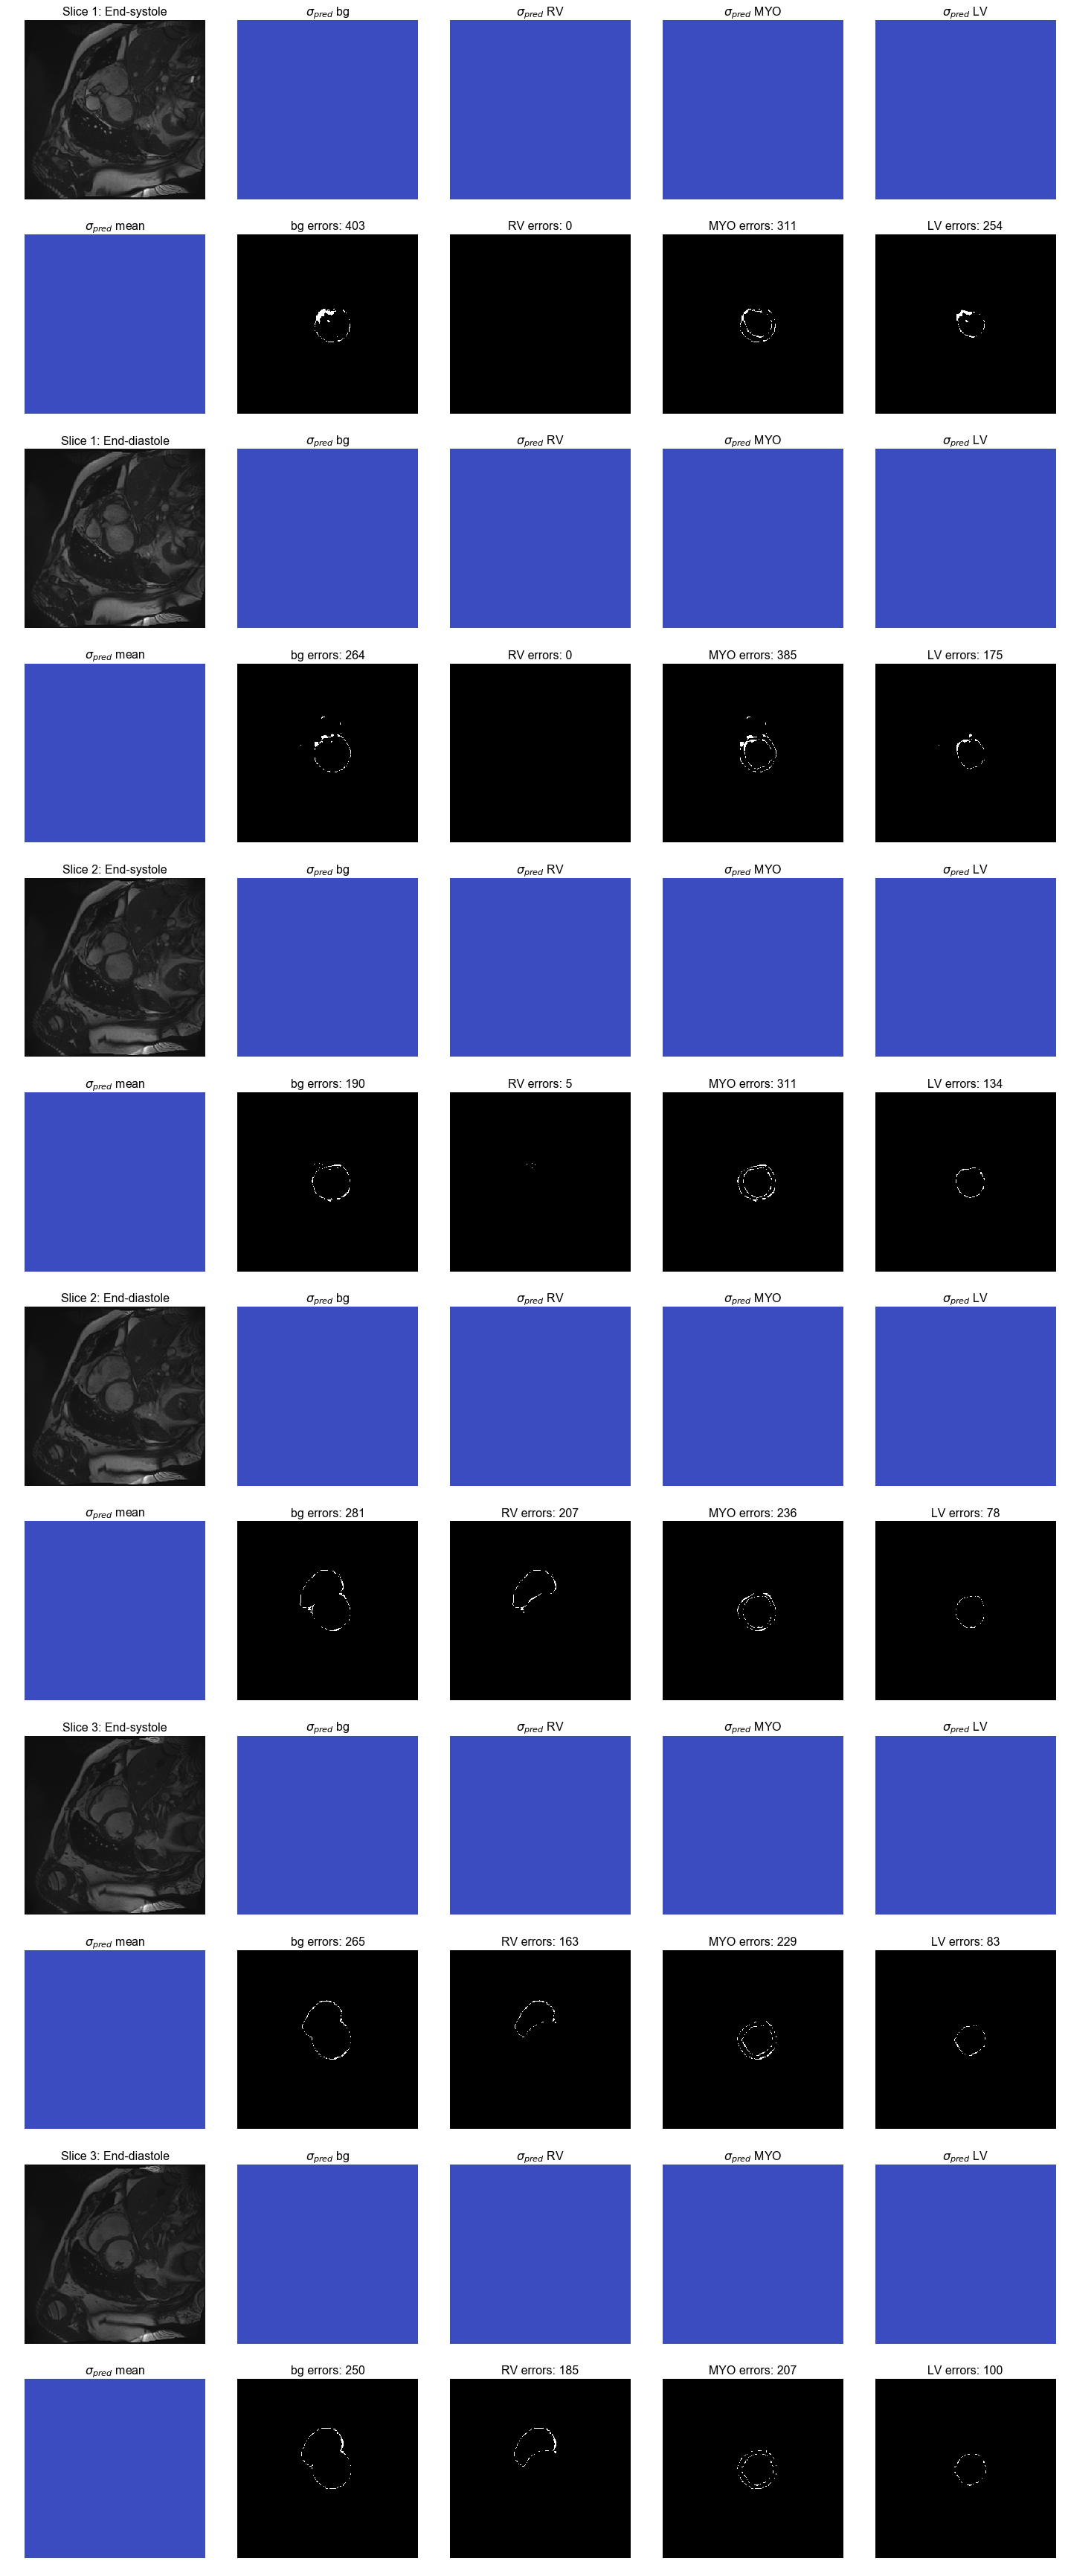

In [85]:
exper_hdl_base.test_results.visualize_prediction_uncertainty(width=20, height=120, slice_range=[0, 1, 2], 
                                                            do_save=False, std_threshold=None)

In [20]:
exp_base_model_exper1 = os.path.join(LOG_DIR, "20180319_10_49_05_dcnnv1_150000E_lr2e02")
exper_base_exper1 = ExperimentHandler.load_experiment(exp_base_model_exper1)
exper_hdl_base_exper1 = ExperimentHandler(exper_base_exper1, use_logfile=False)
exper_hdl_base_exper1.set_root_dir(ROOT_DIR)
exper_hdl_base_exper1.set_model_name("DCNN baseline exper1")

Load from /home/jorg/repository/dcnn_acdc/logs/20180319_10_49_05_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
